# Solution: Raster data needs reprojection

## 📂 Open the source data (in EPSG:3413)

In [1]:
%matplotlib widget
# Set up matplotlib interactive "magic"

In [2]:
import rioxarray
import matplotlib.pyplot as plt
import numpy as np
from rasterio.enums import Resampling
from cartopy import crs as ccrs

epsg_3413 = rioxarray.open_rasterio('../dem_with_altered_metadata.tif')
epsg_3413

<xarray.DataArray (band: 1, y: 561, x: 301)>
[168861 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -8e+05 -7.95e+05 -7.9e+05 ... 6.95e+05 7e+05
  * y            (y) float64 -6e+05 -6.05e+05 -6.1e+05 ... -3.395e+06 -3.4e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:        Area
    TIFFTAG_XRESOLUTION:  1
    TIFFTAG_YRESOLUTION:  1
    scale_factor:         1.0
    add_offset:           0.0
    long_name:            band_data

### Plot the source data

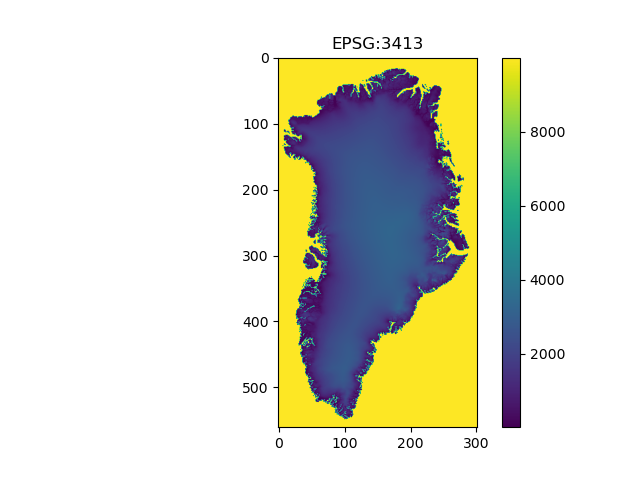

In [3]:
plt.figure()
plot = plt.imshow(epsg_3413[0])

plot.axes.set_title('EPSG:3413')
plt.colorbar()
plt.show()

## 🌐 Reproject the dataset

In [4]:
epsg_4326 = epsg_3413.rio.reproject(
    "EPSG:4326",
    resampling=Resampling.bilinear,
)

### Plot it again!

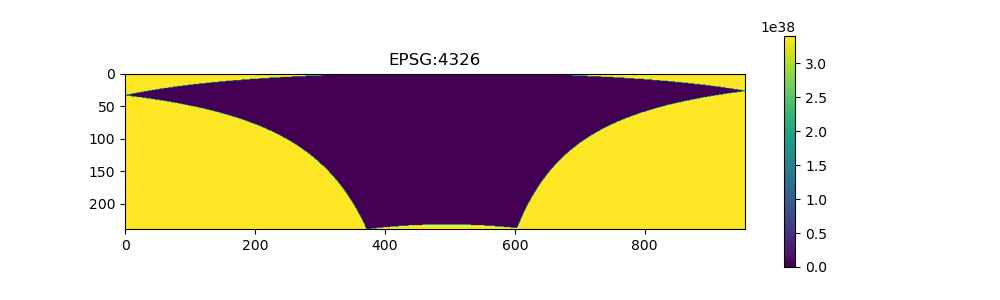

In [23]:
plt.figure(figsize=(10,3))

plot = plt.imshow(epsg_4326[0])
plot.axes.set_title('EPSG:4326')
plt.colorbar()
plt.show()

## ⁉️ What's going on?

This result is clearly wrong. What is this shape? Why is the data "gone", and what does the yellow color represent?

We're seeing the shape of the extent of the original data in purple. The original rectangular shape had to be warped to align to the geographic projection grid. Outside that area, the yellow color is a very large number being used as a NoData value.

This is because this dataset does not have a NoData value correctly set to `9999`. Below we can see that `9999` is being used as the NoData value for the source dataset, but after reprojecting we have a _new_ fill value being added.

In [6]:
expected_nodata = 9999
print(f"Expected NoData value: {expected_nodata}")
print()
print(f"===Pre-reprojection===")
print(f"Shape: {epsg_3413[0].shape}")
print(f"Top-left corner value: {epsg_3413[0][0][0].data}")
print(f"Rasterio NoData value: {epsg_3413[0].rio.nodata}")
print()
print(f"===Post-reprojection===")
print(f"Shape: {epsg_4326[0].shape}")
print(f"Top-left corner value: {epsg_4326[0][0][0].data}")
print(f"Top-center value (should be original NoData): {epsg_4326[0][120,0].data}")
print(f"Rasterio NoData value: {epsg_4326[0].rio.nodata}")
print(f"Xarray FillValue: {epsg_4326[0]._FillValue}")

Expected NoData value: 9999

===Pre-reprojection===
Shape: (561, 301)
Top-left corner value: 9999.0
Rasterio NoData value: None

===Post-reprojection===
Shape: (240, 955)
Top-left corner value: 3.4028234663852886e+38
Top-center value (should be original NoData): 3.4028234663852886e+38
Rasterio NoData value: 3.4028234663852886e+38
Xarray FillValue: 3.402823466e+38


/home/mfisher/.miniconda3/envs/geotools/lib/python3.11/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


## 🥸 Masking the NoData values

We expect the NoData value to be 9999, so let's mask it out.

In [7]:
epsg_4326_da = epsg_4326[0]
epsg_4326_da = epsg_4326_da.where(epsg_4326_da != expected_nodata)

### Plot!

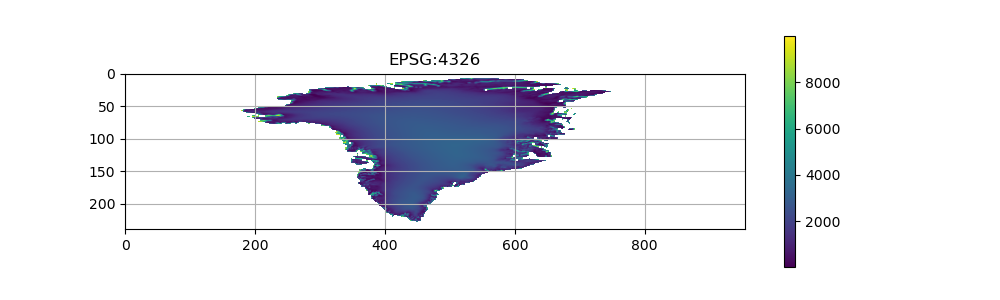

In [22]:
plt.figure(figsize=(10,3))
plot = plt.imshow(epsg_4326_da)
plot.axes.set_title('EPSG:4326')
plot.axes.grid()
plt.colorbar()
plt.show()

## ⁉️ What's going on?

We've successfully masked out the NoData values, but that only applied to the values in the original dataset. This is showing two NoData values: `9999` from the original dataset, and the maximum `Float32` value for pixels outside of the original dataset.

We can mask those out, too:

In [9]:
epsg_4326_da = epsg_4326_da.where(epsg_4326_da <= 9999)

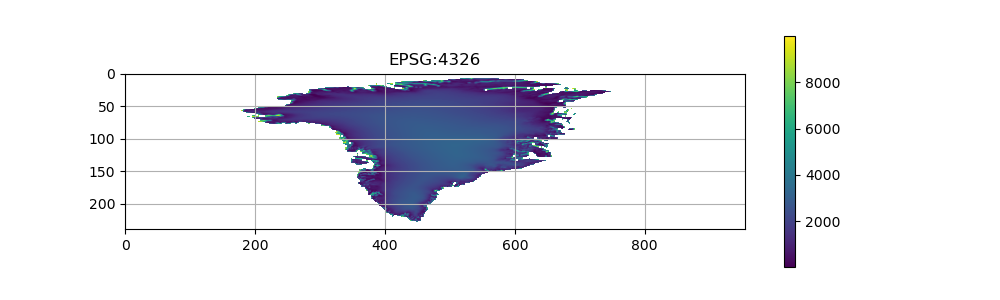

In [21]:
plt.figure(figsize=(10,3))
plot = plt.imshow(epsg_4326_da)
plot.axes.set_title('EPSG:4326')
plot.axes.grid()
plt.colorbar()
plt.show()

This has uncovered another issue! Zoom in on the coastline of Greenland. The edge pixels shouldn't have higher values than interior pixels; the ice sheet is thinner at the edges. These edge pixels were interpolated during the original reprojection because the NoData value was not appropriately set -- normally, NoData pixels aren't used during interpolation. Looks like we need to go back even further to fix this, rather than masking the problem.

## 🌐 Reproject the dataset; 2nd try

First, correctly set the NoData value on the source and mask out the nodata values. _Then_ reproject.

In [11]:
# Replace the nodata value 
epsg_3413_fixed = epsg_3413.where(epsg_3413 != 9999)
epsg_3413_fixed = epsg_3413_fixed.rio.write_nodata(9999, encoded=True)
print(f"NoData encoded as: {epsg_3413_fixed.rio.encoded_nodata}")

epsg_4326_fixed = epsg_3413_fixed.rio.reproject(
    "EPSG:4326",
    resampling=Resampling.bilinear,
)

NoData encoded as: 9999.0


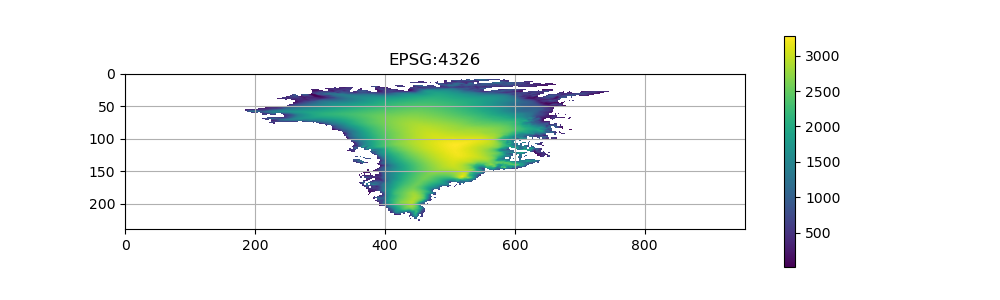

In [20]:
plt.figure(figsize=(10,3))
plot = plt.imshow(epsg_4326_fixed[0])
plot.axes.set_title('EPSG:4326')
plot.axes.grid()
plt.colorbar()
plt.show()